# Q-Learning

Este notebook explica el algoritmo Q-Learning, uno de los algoritmos más importantes en Reinforcement Learning (Aprendizaje por Refuerzo).

## ¿Qué es Q-Learning?

Q-Learning es un algoritmo de aprendizaje por refuerzo sin modelo (model-free) que aprende la política óptima de acción mediante la estimación de valores Q (quality). Es un algoritmo de aprendizaje fuera de política (off-policy) que puede aprender la política óptima independientemente de la política que sigue.

## Conceptos Fundamentales

- **Agente**: Entidad que toma decisiones y realiza acciones
- **Ambiente (Environment)**: El mundo en el que el agente actúa
- **Estado (State)**: Situación actual del ambiente
- **Acción (Action)**: Movimiento que el agente puede realizar
- **Recompensa (Reward)**: Feedback numérico que recibe el agente
- **Q-Value**: Valor esperado de tomar una acción en un estado dado
- **Política (Policy)**: Estrategia que el agente usa para seleccionar acciones


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import Tuple, Dict, List


## Ecuación de Actualización Q-Learning

La ecuación de Bellman para Q-Learning es:

$$Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma \max_{a'} Q(s', a') - Q(s, a)]$$

Donde:
- $Q(s, a)$: Valor Q del estado $s$ y acción $a$
- $\alpha$ (alpha): Tasa de aprendizaje (learning rate)
- $r$: Recompensa inmediata
- $\gamma$ (gamma): Factor de descuento (discount factor)
- $s'$: Estado siguiente
- $\max_{a'} Q(s', a')$: Máximo valor Q del estado siguiente


In [2]:
class QLearningAgent:
    """Agente que aprende usando Q-Learning"""
    
    def __init__(self, n_states, n_actions, learning_rate=0.1, 
                 discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, 
                 epsilon_min=0.01):
        """
        Parámetros:
        - n_states: Número de estados posibles
        - n_actions: Número de acciones posibles
        - learning_rate: Tasa de aprendizaje (alpha)
        - discount_factor: Factor de descuento (gamma)
        - epsilon: Probabilidad inicial de exploración (epsilon-greedy)
        - epsilon_decay: Tasa de decaimiento de epsilon
        - epsilon_min: Valor mínimo de epsilon
        """
        self.n_states = n_states
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Inicializar tabla Q con ceros
        self.q_table = np.zeros((n_states, n_actions))
    
    def choose_action(self, state, training=True):
        """
        Selecciona una acción usando política epsilon-greedy
        
        - Con probabilidad epsilon: acción aleatoria (exploración)
        - Con probabilidad 1-epsilon: mejor acción según Q-table (explotación)
        """
        if training and random.random() < self.epsilon:
            # Exploración: acción aleatoria
            return random.randint(0, self.n_actions - 1)
        else:
            # Explotación: mejor acción
            return np.argmax(self.q_table[state])
    
    def update(self, state, action, reward, next_state, done):
        """
        Actualiza la tabla Q usando la ecuación de Q-Learning
        """
        current_q = self.q_table[state, action]
        
        if done:
            # Si el episodio terminó, no hay estado siguiente
            target_q = reward
        else:
            # Calcular el máximo Q-value del estado siguiente
            max_next_q = np.max(self.q_table[next_state])
            target_q = reward + self.discount_factor * max_next_q
        
        # Actualizar Q-value
        self.q_table[state, action] = current_q + self.learning_rate * (target_q - current_q)
        
        # Decaer epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def get_policy(self):
        """Retorna la política aprendida (mejor acción para cada estado)"""
        return np.argmax(self.q_table, axis=1)


## Ejemplo: Laberinto Simple

Vamos a implementar Q-Learning para que un agente aprenda a navegar por un laberinto.


In [3]:
class MazeEnvironment:
    """Ambiente de laberinto simple"""
    
    def __init__(self, maze_size=5):
        """
        Laberinto representado como una cuadrícula:
        - 0: Espacio libre
        - 1: Pared
        - 2: Meta
        """
        self.maze_size = maze_size
        self.maze = np.zeros((maze_size, maze_size))
        
        # Crear un laberinto simple
        # Paredes en algunas posiciones
        self.maze[1, 1] = 1
        self.maze[1, 2] = 1
        self.maze[2, 1] = 1
        self.maze[3, 3] = 1
        
        # Meta en la esquina inferior derecha
        self.maze[maze_size-1, maze_size-1] = 2
        
        # Posición inicial
        self.state = 0  # Estado inicial (0, 0)
        self.start_state = 0
        
    def reset(self):
        """Reinicia el ambiente al estado inicial"""
        self.state = self.start_state
        return self.state
    
    def state_to_pos(self, state):
        """Convierte estado (número) a posición (fila, columna)"""
        return (state // self.maze_size, state % self.maze_size)
    
    def pos_to_state(self, row, col):
        """Convierte posición (fila, columna) a estado (número)"""
        return row * self.maze_size + col
    
    def step(self, action):
        """
        Ejecuta una acción y retorna (next_state, reward, done)
        
        Acciones:
        0: Arriba
        1: Derecha
        2: Abajo
        3: Izquierda
        """
        row, col = self.state_to_pos(self.state)
        
        # Movimientos: arriba, derecha, abajo, izquierda
        moves = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        dr, dc = moves[action]
        
        new_row = row + dr
        new_col = col + dc
        
        # Verificar límites
        if new_row < 0 or new_row >= self.maze_size or \
           new_col < 0 or new_col >= self.maze_size:
            # Movimiento inválido: quedarse en el mismo lugar
            return self.state, -0.1, False
        
        # Verificar si hay pared
        if self.maze[new_row, new_col] == 1:
            # Chocar con pared: penalización pequeña
            return self.state, -0.5, False
        
        # Movimiento válido
        new_state = self.pos_to_state(new_row, new_col)
        self.state = new_state
        
        # Verificar si llegó a la meta
        if self.maze[new_row, new_col] == 2:
            return new_state, 10.0, True  # Recompensa grande por llegar a la meta
        
        # Movimiento normal: pequeña penalización por paso
        return new_state, -0.1, False
    
    def render(self):
        """Visualiza el laberinto"""
        display = self.maze.copy()
        row, col = self.state_to_pos(self.state)
        display[row, col] = 3  # Marcar posición del agente
        
        print("Laberinto:")
        for r in range(self.maze_size):
            for c in range(self.maze_size):
                if display[r, c] == 0:
                    print(".", end=" ")
                elif display[r, c] == 1:
                    print("#", end=" ")
                elif display[r, c] == 2:
                    print("G", end=" ")  # Goal
                elif display[r, c] == 3:
                    print("A", end=" ")  # Agent
            print()


In [4]:
# Crear ambiente y agente
env = MazeEnvironment(maze_size=5)
n_states = env.maze_size * env.maze_size
n_actions = 4  # Arriba, derecha, abajo, izquierda

agent = QLearningAgent(
    n_states=n_states,
    n_actions=n_actions,
    learning_rate=0.1,
    discount_factor=0.95,
    epsilon=1.0,
    epsilon_decay=0.995,
    epsilon_min=0.01
)

# Entrenar el agente
n_episodes = 500
episode_rewards = []
episode_lengths = []

for episode in range(n_episodes):
    state = env.reset()
    total_reward = 0
    steps = 0
    done = False
    
    while not done and steps < 100:  # Límite de pasos por episodio
        action = agent.choose_action(state, training=True)
        next_state, reward, done = env.step(action)
        agent.update(state, action, reward, next_state, done)
        
        state = next_state
        total_reward += reward
        steps += 1
    
    episode_rewards.append(total_reward)
    episode_lengths.append(steps)
    
    if (episode + 1) % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        avg_length = np.mean(episode_lengths[-50:])
        print(f"Episodio {episode + 1}: Recompensa promedio = {avg_reward:.2f}, "
              f"Pasos promedio = {avg_length:.1f}, Epsilon = {agent.epsilon:.3f}")

print("\nEntrenamiento completado!")


Episodio 50: Recompensa promedio = 7.62, Pasos promedio = 19.5, Epsilon = 0.010
Episodio 100: Recompensa promedio = 9.29, Pasos promedio = 8.0, Epsilon = 0.010
Episodio 150: Recompensa promedio = 9.30, Pasos promedio = 8.0, Epsilon = 0.010
Episodio 200: Recompensa promedio = 9.30, Pasos promedio = 8.0, Epsilon = 0.010
Episodio 250: Recompensa promedio = 9.30, Pasos promedio = 8.0, Epsilon = 0.010
Episodio 300: Recompensa promedio = 9.30, Pasos promedio = 8.0, Epsilon = 0.010
Episodio 350: Recompensa promedio = 9.29, Pasos promedio = 8.1, Epsilon = 0.010
Episodio 400: Recompensa promedio = 9.27, Pasos promedio = 8.2, Epsilon = 0.010
Episodio 450: Recompensa promedio = 9.30, Pasos promedio = 8.0, Epsilon = 0.010
Episodio 500: Recompensa promedio = 9.28, Pasos promedio = 8.1, Epsilon = 0.010

Entrenamiento completado!


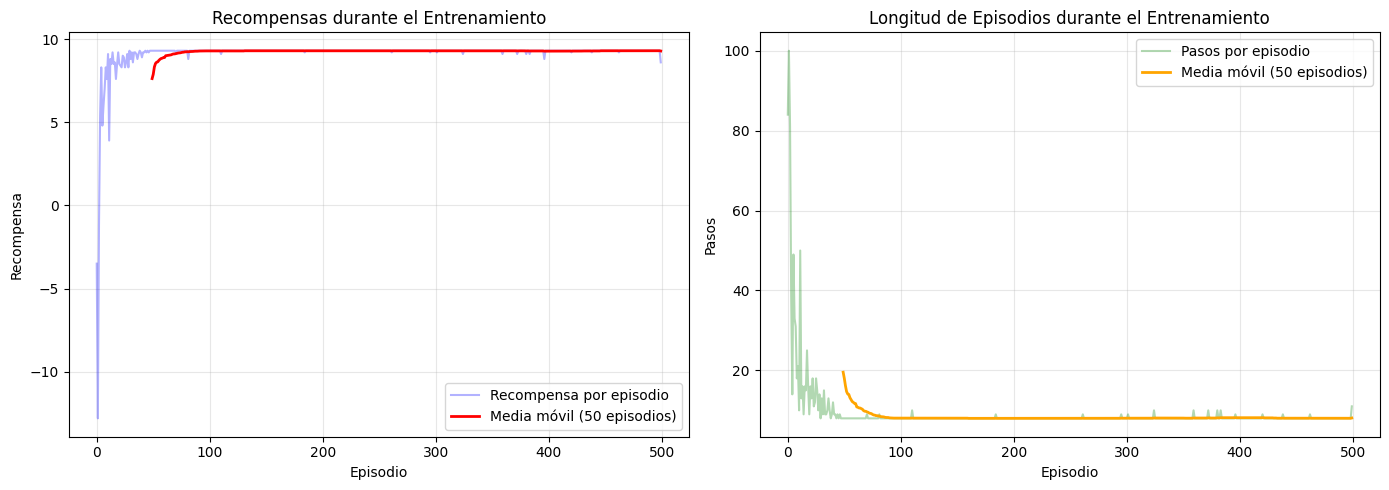

In [5]:
# Visualizar el aprendizaje
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Recompensas por episodio
ax1.plot(episode_rewards, alpha=0.3, color='blue', label='Recompensa por episodio')
# Media móvil
window = 50
if len(episode_rewards) >= window:
    moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    ax1.plot(range(window-1, len(episode_rewards)), moving_avg, 
             color='red', linewidth=2, label=f'Media móvil ({window} episodios)')
ax1.set_xlabel('Episodio')
ax1.set_ylabel('Recompensa')
ax1.set_title('Recompensas durante el Entrenamiento')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Longitud de episodios
ax2.plot(episode_lengths, alpha=0.3, color='green', label='Pasos por episodio')
if len(episode_lengths) >= window:
    moving_avg = np.convolve(episode_lengths, np.ones(window)/window, mode='valid')
    ax2.plot(range(window-1, len(episode_lengths)), moving_avg, 
             color='orange', linewidth=2, label=f'Media móvil ({window} episodios)')
ax2.set_xlabel('Episodio')
ax2.set_ylabel('Pasos')
ax2.set_title('Longitud de Episodios durante el Entrenamiento')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [6]:
# Probar el agente entrenado
print("Probando el agente entrenado:")
state = env.reset()
env.render()
print()

steps = 0
done = False
path = [env.state_to_pos(state)]

while not done and steps < 20:
    action = agent.choose_action(state, training=False)  # Sin exploración
    next_state, reward, done = env.step(action)
    state = next_state
    path.append(env.state_to_pos(state))
    steps += 1
    
    print(f"Paso {steps}: Acción = {['Arriba', 'Derecha', 'Abajo', 'Izquierda'][action]}")
    env.render()
    print()
    
    if done:
        print(f"¡Meta alcanzada en {steps} pasos!")
        break

print(f"Camino seguido: {path}")


Probando el agente entrenado:
Laberinto:
A . . . . 
. # # . . 
. # . . . 
. . . # . 
. . . . G 

Paso 1: Acción = Derecha
Laberinto:
. A . . . 
. # # . . 
. # . . . 
. . . # . 
. . . . G 

Paso 2: Acción = Derecha
Laberinto:
. . A . . 
. # # . . 
. # . . . 
. . . # . 
. . . . G 

Paso 3: Acción = Derecha
Laberinto:
. . . A . 
. # # . . 
. # . . . 
. . . # . 
. . . . G 

Paso 4: Acción = Derecha
Laberinto:
. . . . A 
. # # . . 
. # . . . 
. . . # . 
. . . . G 

Paso 5: Acción = Abajo
Laberinto:
. . . . . 
. # # . A 
. # . . . 
. . . # . 
. . . . G 

Paso 6: Acción = Abajo
Laberinto:
. . . . . 
. # # . . 
. # . . A 
. . . # . 
. . . . G 

Paso 7: Acción = Abajo
Laberinto:
. . . . . 
. # # . . 
. # . . . 
. . . # A 
. . . . G 

Paso 8: Acción = Abajo
Laberinto:
. . . . . 
. # # . . 
. # . . . 
. . . # . 
. . . . A 

¡Meta alcanzada en 8 pasos!
Camino seguido: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4)]


## Visualización de la Tabla Q

Podemos visualizar los valores Q aprendidos para entender qué acciones prefiere el agente en cada estado.


In [7]:
# Visualizar la tabla Q
print("Tabla Q (valores para cada estado-acción):")
print("Estados son filas, acciones son columnas [Arriba, Derecha, Abajo, Izquierda]")
print("\n", agent.q_table)

# Visualizar la política aprendida
policy = agent.get_policy()
print("\nPolítica aprendida (mejor acción para cada estado):")
action_names = ['↑', '→', '↓', '←']
for state in range(n_states):
    row, col = env.state_to_pos(state)
    if env.maze[row, col] == 1:  # Pared
        print("#", end=" ")
    elif env.maze[row, col] == 2:  # Meta
        print("G", end=" ")
    else:
        print(action_names[policy[state]], end=" ")
    
    if (state + 1) % env.maze_size == 0:
        print()  # Nueva línea al final de cada fila


Tabla Q (valores para cada estado-acción):
Estados son filas, acciones son columnas [Arriba, Derecha, Abajo, Izquierda]

 [[-0.28679617  6.38004755 -0.2856098   0.3337201 ]
 [ 1.56322711  6.82110269  0.35647226 -0.2263646 ]
 [ 0.07749309  7.28537125  0.14321502  1.50624843]
 [-0.09686708  7.774075   -0.09260776  0.59952336]
 [ 0.72407802  0.72796376  8.2885     -0.0600892 ]
 [-0.23685115 -0.25056957 -0.2377714  -0.2430331 ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.05231111  0.87477161 -0.05103029 -0.13334198]
 [-0.0398425  -0.02245415  8.83       -0.03879298]
 [-0.194014   -0.2360845  -0.14494043 -0.17246651]
 [ 0.          0.          0.          0.        ]
 [-0.13825025 -0.03951948 -0.04053163 -0.05      ]
 [-0.03071727  1.0260699  -0.095      -0.03163293]
 [-0.01995     1.53588135  9.4        -0.02336822]
 [-0.11682796 -0.1078818   0.11893956 -0.10729084]
 [-0.09975    -0.06376245  0.02652445 -0.06619245]
 [-0.043809

## Parámetros Importantes

### Learning Rate (α)
- Controla qué tan rápido aprende el agente
- Valores altos: aprendizaje rápido pero inestable
- Valores bajos: aprendizaje lento pero estable
- Típico: 0.1 - 0.3

### Discount Factor (γ)
- Determina la importancia de recompensas futuras
- Valores cercanos a 1: el agente valora recompensas futuras
- Valores cercanos a 0: el agente solo valora recompensas inmediatas
- Típico: 0.9 - 0.99

### Epsilon (ε) - Exploración vs Explotación
- Epsilon-greedy: balance entre exploración y explotación
- Alto epsilon: más exploración (aprende más)
- Bajo epsilon: más explotación (usa lo aprendido)
- Epsilon decay: reduce exploración con el tiempo

## Ventajas y Desventajas

**Ventajas:**
- No requiere modelo del ambiente (model-free)
- Puede aprender la política óptima sin seguirla (off-policy)
- Relativamente simple de implementar
- Funciona bien en espacios de estados discretos pequeños

**Desventajas:**
- No escala bien a espacios de estados grandes (curse of dimensionality)
- Requiere discretización para estados continuos
- Puede ser lento en convergencia
- No maneja bien la aleatoriedad en transiciones

## Aplicaciones

- Juegos (ajedrez, damas, videojuegos)
- Robótica (navegación, control)
- Sistemas de recomendación
- Trading algorítmico
- Optimización de recursos
